# Creating features and target

## import packages and DataFrame

In [52]:
from features import Dataframe
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
polkadot = Dataframe().get_dataframe()

In [3]:
polkadot.head()

,date,current_price,current_price_sats,market_cap,reddit_post_48h,reddit_comment_48h,reddit_subscribers,reddit_active_accounts,public_interest_stats,Value,Value_classification
0,2020-08-19,2.936665,25024.566687,0.000000e+00,0.000,0.750,193,7.200000,NaN,80,Extreme Greed
1,2020-08-20,2.936665,25024.566687,0.000000e+00,0.000,0.667,212,5.500000,NaN,75,Greed
2,2020-08-21,2.898791,24435.409268,0.000000e+00,0.000,1.727,237,6.333333,NaN,81,Extreme Greed
3,2020-08-22,2.871923,24934.417517,0.000000e+00,0.417,2.750,269,8.538462,NaN,78,Extreme Greed
4,2020-08-23,4.481389,38367.856477,4.028277e+09,1.091,5.364,313,16.500000,NaN,76,Extreme Greed


## create target

> create price in two days as target, then convert that into 0 (price less than the day before)
or 1 (price more than the day before)

In [4]:
polkadot['predict'] = polkadot['current_price'].shift(-2)

In [5]:
polkadot['predict'] = pd.Series(np.where(polkadot['predict'].values < polkadot['current_price'], 0, 1),
          polkadot.index)

## create new features

In [6]:
polkadot['price_ema5'] = polkadot['current_price'].ewm(span=5, adjust=False).mean()
polkadot['price_ema20'] = polkadot['current_price'].ewm(span=20, adjust=False).mean()
polkadot['price_ema50'] = polkadot['current_price'].ewm(span=50, adjust=False).mean()

polkadot['fear_ema5'] = polkadot['Value'].ewm(span=2, adjust=False).mean()
polkadot['fear_ema20'] = polkadot['Value'].ewm(span=20, adjust=False).mean()
polkadot['fear_ema50'] = polkadot['Value'].ewm(span=50, adjust=False).mean()

polkadot['fear_change_2_days'] = polkadot['Value'] - polkadot['Value'].shift(2)
polkadot['fear_change_1_week'] = polkadot['Value'] - polkadot['Value'].shift(7)
polkadot['fear_change_2_weeks'] = polkadot['Value'] - polkadot['Value'].shift(14)

polkadot['reddit_post_ema5'] = polkadot['reddit_post_48h'].ewm(span=5, adjust=False).mean()
polkadot['reddit_post_ema20'] = polkadot['reddit_post_48h'].ewm(span=20, adjust=False).mean()
polkadot['reddit_post_ema50'] = polkadot['reddit_post_48h'].ewm(span=50, adjust=False).mean()

polkadot['reddit_change_2_days'] = polkadot['reddit_post_48h'] - polkadot['reddit_post_48h'].shift(2)
polkadot['reddit_change_1_week'] = polkadot['reddit_post_48h'] - polkadot['reddit_post_48h'].shift(7)
polkadot['reddit_change_2_weeks'] = polkadot['reddit_post_48h'] - polkadot['reddit_post_48h'].shift(14)

polkadot['sats_ema5'] = polkadot['current_price_sats'].ewm(span=5, adjust=False).mean()
polkadot['sats_ema20'] = polkadot['current_price_sats'].ewm(span=20, adjust=False).mean()
polkadot['sats_ema50'] = polkadot['current_price_sats'].ewm(span=50, adjust=False).mean()

polkadot['sats_change_2_days'] = polkadot['current_price_sats'] - polkadot['current_price_sats'].shift(2)
polkadot['sats_change_1_week'] = polkadot['current_price_sats'] - polkadot['current_price_sats'].shift(7)
polkadot['sats_change_2_weeks'] = polkadot['current_price_sats'] - polkadot['current_price_sats'].shift(14)

polkadot['price_change_2_days'] = polkadot['current_price'] - polkadot['current_price'].shift(2)
polkadot['price_change_1_week'] = polkadot['current_price'] - polkadot['current_price'].shift(7)
polkadot['price_change_2_weeks'] = polkadot['current_price'] - polkadot['current_price'].shift(14)

In [7]:
polkadot.dropna(inplace=True)

In [8]:
df = Dataframe().get_features_targets()

## find optimal features

### create features and target

In [9]:
X = df.drop(columns=['predict', 'date', 'Value_classification'])
y = df['predict']

### use RobustScaler to scale features

In [10]:
scaler = RobustScaler().fit(X)
X_scaled = scaler.transform(X)

### use feature permutation to find most important features

In [11]:
regressor = KNeighborsClassifier().fit(X_scaled, y)
permutation_score = permutation_importance(regressor, X_scaled, y, n_repeats=10)
importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score.importances_mean)).T)
importance_df.columns=['feature','score decrease']

importance_df['score decrease'] = abs(importance_df['score decrease'])
importance_df = importance_df.sort_values(by="score decrease", ascending = False)

In [12]:
features = importance_df['feature']

### test different classifiers

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [113]:
k_regressor = KNeighborsClassifier().fit(X_train, y_train)
s_model = SVC().fit(X_train, y_train)
classifier = DecisionTreeClassifier().fit(X_train, y_train)
random_classifier = RandomForestClassifier().fit(X_train, y_train)
ada = AdaBoostClassifier().fit(X_train, y_train)
gradient = GradientBoostingClassifier().fit(X_train, y_train)

In [114]:
scores = pd.DataFrame(columns=['scores'], index=['KNeighbors', 'Support Vector', 'Decision Tree',
                                                'Random Forest', 'Ada Boost', 'Gradient Boost'], 
                      data=[k_regressor.score(X_test, y_test), s_model.score(X_test, y_test),
                           classifier.score(X_test, y_test), random_classifier.score(X_test, y_test),
                           ada.score(X_test, y_test), gradient.score(X_test, y_test)])

In [115]:
scores

,scores
KNeighbors,0.481818
Support Vector,0.572727
Decision Tree,0.654545
Random Forest,0.663636
Ada Boost,0.636364
Gradient Boost,0.627273


<AxesSubplot:xlabel='scores'>

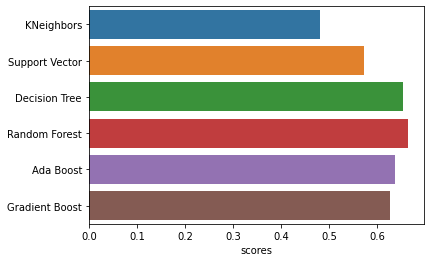

In [125]:
sns.barplot(y=scores.index, x=scores['scores'])
plt.xlabel('Score')
plt.title('')

> Let's experiment more with DecisionTreeClassifier to see if we can improve results

In [19]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[31 24]
 [23 32]]
              precision    recall  f1-score   support

           0       0.57      0.56      0.57        55
           1       0.57      0.58      0.58        55

    accuracy                           0.57       110
   macro avg       0.57      0.57      0.57       110
weighted avg       0.57      0.57      0.57       110



# Decision Tree Classifier